## Data Preparation, Machine Learning, and Prediction

This notebook outlines the following steps:

1. **Importing Cleaned Data**  
   Cleaned jerky drying data is loaded from the `pdata` directory.

2. **Normalizing and Preparing Data for Machine Learning**  
   Weight values are normalized and stored in the `ldata` directory to be used for training.

3. **Training Machine Learning Models**  
   The normalized, curve-fitted weight data is used to train models that predict drying behavior.

4. **Predicting Drying Times**  
   Trained models are used to predict drying times under varying constraints such as temperature and humidity.

### Note on Data Precision

A limitation of the original data collection process is that weight readings were recorded as **integers only**, which results in repeated values like `234, 234, 234, 234`, rather than finer resolution values such as `234.9, 234.7, 234.5, 234.3`.

To address this:

- The data is **normalized**, and  
- A **curve fitting** process is applied to smooth and interpolate the weight values.

### Data Coverage Limitations

The dataset lacks sufficient samples at the extremes of the input range, particularly:

- Limited data for **high temperature** and **high humidity** conditions.
- No coverage for **high temperature with low humidity**, which leads to inaccurate predictions for this combination.


In [1]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# Set Pandas to display numbers without scientific notation
pd.set_option('display.float_format', '{:.3f}'.format)

# Set data folders
cleaned_data_folder = 'pdata'  #1 Cleaned data
normalized_data_folder = 'ldata' #2 Normalized data with extended features

#Load data
all_clean_files = [f for f in os.listdir(cleaned_data_folder) if f.endswith('.csv')]


### Curve Fitting and Normalized Data Generation

In this cell, we process each cleaned data file to prepare it for machine learning:

1. **Read and Clean Data**  
   - Load each CSV file and reset the time to start from zero (in 30-minute intervals).
   - Drop irrelevant columns and normalize the weight based on its initial value.

2. **Data Trimming and Curve Fitting**  
   - Apply an exponential decay model to fit the weight data.
   - If the dataset is shorter than a predefined length, it is padded with predicted values.
   - If it's too long, it's trimmed.

3. **Fitted Weights and Export**  
   - Add the fitted curve data as a new column.
   - Save the processed DataFrame to the `ldata` directory with a `_norm` suffix for later use in machine learning.

The process stops after a maximum of `MAX_FILES` have been handled to prevent overloading.


In [ ]:
import numpy as np
from scipy.optimize import curve_fit

MAX_FILES = 1000  # Maximum number of files to process

#Raise an error if overflow occurs in numpy operations, not just a warning
np.seterr(over='raise')

# Drying function (exponential decay model)
def drying_curve(time, a, b, c):
    return a * np.exp(-b * time) + c

#Iterate over all files in the cleaned data folder
for i, file in enumerate(all_clean_files):
    print(f"\rProcessing file {i}, {file}", end='', flush=True)
    df = pd.read_csv(os.path.join(cleaned_data_folder, file))
    
    # New reference to the DataFrame
    data=df

    # Get the value from row 0, column 1 (which is 'Unix_time_Stamp' column, index 2)
    value_to_subtract = data.iloc[0, 1]

    #print(f"Value to subtract: {value_to_subtract}")

    # Subtract this value from the entire 'Unix_time_Stamp' column so that the first value becomes 0
    data['Unix_time_Stamp'] = (data['Unix_time_Stamp'] - value_to_subtract)/1800
    
    # Get the name of the last column
    last_column_name = data.columns[-1]

    # Rename the last column to 'Weight'
    data = data.rename(columns={last_column_name: 'Weight'})

    # Get the value from row 0, column 5 (which is 'Weight' column, index 2)
    value_to_normalize = data.iloc[0, 5]

    #print(f"Value to value_to_normalize: {value_to_normalize}")

    # Subtract this value from the entire 'Unix_time_Stamp' column
    data['Weight'] = (data['Weight'])/value_to_normalize

    # Drop the 3rd column by name
    data = data.drop('Date', axis=1)

    # Rename 'Unix_time_Stamp' to 'time'
    data = data.rename(columns={'Unix_time_Stamp': 'Time'})
    
    # Convert the "Time" column from float to integer
    data['Time'] = data['Time'].astype(int)

    # Calculate the average Temp and Humidity
    avg_temp = data['Temp'].mean()
    avg_temp = round(avg_temp, 1)
    avg_humidity = data['Humidity'].mean()
    avg_humidity = round(avg_humidity, 1)

    # Set the trim parameter to 1600 e.g. 1600 / 2 = 800 hours
    # This means we will only keep the first 800 hours of data
    trim_value = 1600
    time = np.arange(len(data))  # Create a time array of the same length
    time_ext = np.arange(trim_value)

    # Set the bounds to avoid overflow errors    
    popt1, pcov = curve_fit(drying_curve, time, data['Weight'], bounds=([0, 0, 0], [np.inf, np.inf, np.inf]))
    a, b, c = popt1

    # Generate fitted values using the model
    fitted_weights_dev1_ext = drying_curve(time_ext, a, b, c)

    # Ensure the DataFrame is at least 'trim_value' long, and truncate if necessary
    if len(data) > trim_value:
        data = data.iloc[:trim_value]
        #print(f"\r\nDataFrame trimmed to {trim_value} rows.", end='', flush=True)

    # Pad the DataFrame with NaN values if it's shorter than trim_value
    if len(data) < trim_value:

        #print(f"\r\nDataFrame padded to {trim_value} rows.", end='\r\n', flush=True)

        # Calculate how many rows we need to add
        rows_to_add = trim_value - len(data)
        
        # Get the last value of Time
        last_time = data['Time'].iloc[-1]
        
        # Create new rows with padded values with fitted model values calculated above
        padding = pd.DataFrame({
            'Jerky_ID': [data['Jerky_ID'].iloc[0]] * rows_to_add,  # Assuming Jerky_ID remains constant
            'Time': np.arange(last_time + 1, last_time + 1 + rows_to_add),  # Continue Time from the last value
            'Temp': [avg_temp] * rows_to_add,  # Use average Temp
            'Humidity': [avg_humidity] * rows_to_add,  # Use average Humidity
            'Weight': [np.nan] * rows_to_add,  # Leave Weight as NaN
            'fitted_weights': fitted_weights_dev1_ext[len(data):]  # Fill in the remaining fitted weights
        })
        
        # Append the padded rows to the original DataFrame
        data = pd.concat([data, padding], ignore_index=True)

    # Add 'fitted_weights' column from fitted values
    data['fitted_weights'] = fitted_weights_dev1_ext

    # Construct the new filename by splitting the original and appending '_norm'
    base_name, ext = os.path.splitext(file)  # Split into name and extension
    new_filename = f"{base_name}_norm{ext}"  # Append '_norm' to the base name

    # Create the full path for saving
    full_path = os.path.join(normalized_data_folder, new_filename)

    # Write the DataFrame to the new CSV file
    data.to_csv(full_path, index=False)  # index=False to avoid writing row indices

    print(f"\rDataFrame written to {full_path}, Processed {i+1} files", end='', flush=True)
    #display(data)
    
    if i>MAX_FILES:
        print(f"\n\rToo many files to process, stopping at {i+1} files.\r\n")
        break


### Load Normalized Data for Machine Learning

In this cell, we load all normalized CSV files containing preprocessed jerky drying data:

1. **File Discovery**  
   - Lists all `.csv` files in the `ldata` (normalized data) directory.

2. **Memory Cleanup**  
   - Clears any previous DataFrame references to free up memory.

3. **Data Loading and Concatenation**  
   - Reads each file into a temporary DataFrame and appends it to a list.
   - Merges all individual DataFrames into one large DataFrame.

4. **Data Type Conversion**  
   - Ensures all key columns (`Time`, `Temp`, `Humidity`, `Weight`, and `fitted_weights`) are in the correct numeric format.

The result is a single, consolidated DataFrame ready for machine learning model training.


In [3]:

#Get list of all files in the normalized data folder 
all_normalized_files = [f for f in os.listdir(normalized_data_folder) if f.endswith('.csv')]
print(f"\n\rFound {len(all_normalized_files)} normalized files in {normalized_data_folder}.\r\n")

# Remove dataframe reference
del data

#Ensure dfs is empty before appending
dfs = []

# Iterate over all files in the normalized data folder
for file in all_normalized_files:
    df = pd.read_csv(os.path.join(normalized_data_folder, file))
    dfs.append(df)
    
# Merge all the dataframes into one
data = pd.concat(dfs, ignore_index=True)

# Convert data types if necessary
data['Time'] = data['Time'].astype(int)
data['Temp'] = data['Temp'].astype(float)
data['Humidity'] = data['Humidity'].astype(float)
data['Weight'] = data['Weight'].astype(float)
data['fitted_weights'] = data['fitted_weights'].astype(float)

# Display the modified DataFrame
display(data)


Found 101 normalized files in ldata.



,Jerky_ID,Time,Temp,Humidity,Weight,fitted_weights
0,"0,1",0,22.100,30.700,1.000,1.000
1,"0,1",1,22.100,29.100,0.996,0.997
2,"0,1",2,21.100,29.600,0.993,0.994
3,"0,1",3,20.600,29.800,0.990,0.991
4,"0,1",4,20.200,30.500,0.987,0.988
...,...,...,...,...,...,...
161595,"9,5",1595,19.300,28.100,NaN,0.557
161596,"9,5",1596,19.300,28.100,NaN,0.557
161597,"9,5",1597,19.300,28.100,NaN,0.557
161598,"9,5",1598,19.300,28.100,NaN,0.557


### Feature Engineering for Machine Learning

In this cell, we define and generate the lag features that will be used in our machine learning model:

1. **Lag Feature Creation**  
   - We create lag features based on the `fitted_weights` column. The number of lag features is controlled by the variable `FEATURE_DEPTH`, which is set to 3 in this case. This means we generate 3 previous time steps (lags) for each data point.

2. **Data Preprocessing**  
   - After adding the lag features, rows with `NaN` values (due to shifting) are removed to ensure clean data for model training.

The result is a DataFrame with added lag features ready for machine learning.


In [15]:
# How many lag features to create
FEATURE_DEPTH = 3  

# Create features based on the current time
def create_features(df):
    
    for i in range(1, FEATURE_DEPTH + 1):
        df[f'Weight_Lag_{i}'] = df['fitted_weights'].shift(i)
    return df
    
data = create_features(data)
data.dropna(inplace=True)  # Drop rows with NaN values

display(data)


,Jerky_ID,Time,Temp,Humidity,Weight,fitted_weights,Weight_Lag_1,Weight_Lag_2,Weight_Lag_3
6,"0,1",6,20.100,30.300,0.980,0.982,0.985,0.988,0.991
7,"0,1",7,20.200,30.100,0.978,0.979,0.982,0.985,0.988
8,"0,1",8,19.900,30.500,0.974,0.977,0.979,0.982,0.985
9,"0,1",9,20.000,30.300,0.972,0.974,0.977,0.979,0.982
10,"0,1",10,20.000,30.200,0.970,0.971,0.974,0.977,0.979
...,...,...,...,...,...,...,...,...,...
160184,"9,5",184,18.600,26.600,0.637,0.638,0.639,0.640,0.641
160185,"9,5",185,18.600,26.600,0.637,0.638,0.638,0.639,0.640
160186,"9,5",186,18.700,26.600,0.637,0.637,0.638,0.638,0.639
160187,"9,5",187,18.800,26.900,0.637,0.636,0.637,0.638,0.638


### Machine Learning Model and Evaluation

In this cell, we train and evaluate a machine learning model:

1. **Feature and Target Setup**  
   - We define the `features` (which includes `Time`, `Temp`, `Humidity`, and lag features) and the `target` (which is the `fitted_weights` column) for the model.

2. **Data Splitting**  
   - The data is split into training and testing sets using `train_test_split`, with 80% for training and 20% for testing.

3. **Model Initialization and Training**  
   - We initialize a `RandomForestRegressor` model (alternatively, an `XGBRegressor` model is available) and train it using the training data.

4. **Model Evaluation**  
   - The model is evaluated using the Mean Squared Error (MSE), which measures the model's prediction accuracy.

The resulting MSE value is printed to assess model performance.


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor

# Define your features and target variable
lag_features = [f'Weight_Lag_{i}' for i in range(1, FEATURE_DEPTH + 1)]
features = data[['Time', 'Temp', 'Humidity'] + lag_features]
target = data['fitted_weights']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Initialize and train the model
model = RandomForestRegressor(n_estimators=100, random_state=42)
#model = XGBRegressor(n_estimators=100, learning_rate=0.05, random_state=42)
model.fit(X_train, y_train)

# Evaluate the model
predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error: {mse}')


### Predicting Curing Time and Plotting the Results

In this cell, we use the previously trained machine learning model to predict the curing time for jerky based on input temperature, humidity, and previous weight values.

1. **Input Values**  
   - We define the previous temperature, humidity, and previous weights (lag features) that the model will use to predict the curing time.

2. **Model Prediction**  
   - The model is used to predict the weight at each future time step (up to 600 steps or 12.5 days in 30-minute intervals).
   - The loop iterates over the next 600 time steps, updating the lag weights and appending the predicted weights to the `time_list` and `weight_list`.

3. **Stopping Condition**  
   - The prediction stops once the normalized weight reaches a certain threshold (`NORMARLIZED_CURE_WEIGHT`), indicating that the jerky has cured.

4. **Plotting the Results**  
   - A plot is generated showing the predicted weight over time.
   - If the jerky cures before reaching the maximum time, the plot reflects the actual curing time. Otherwise, it shows that the maximum time was reached without curing.

The plot is displayed with labels and a title indicating whether the jerky cured or not within the given time.


Future Time: 5.3 days, Predicted Weight: 0.599494


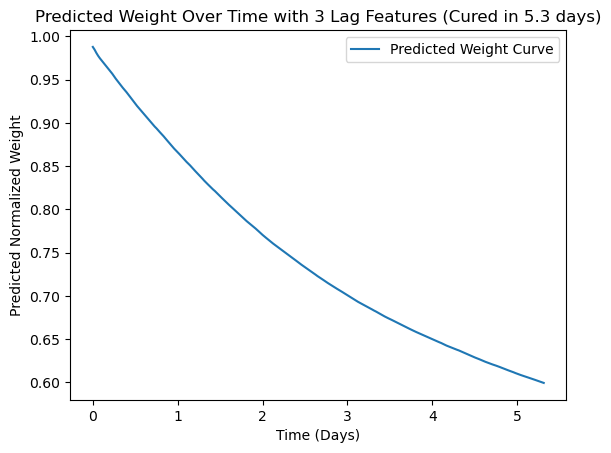

In [16]:
import matplotlib.pyplot as plt

#---------------Input your values here---------------------------
prev_temp=20 # Example: 20 degrees Celsius
prev_humidity=20 # Example: 20% humidity

previous_weight_1=243/243
previous_weight_2=242/243
previous_weight_3=241/243
# previous_weight_4=240/243
# previous_weight_5=239/243
# previous_weight_6=238/243
# previous_weight_7=237/243
# previous_weight_8=236/243
# previous_weight_9=235/243
# previous_weight_10=234/243

lag_weights = [previous_weight_3, previous_weight_2, previous_weight_1]

# Lists to store time and predicted weight
time_list = []
weight_list = []

def predict_future_weight(time, temp, humidity, lag_weights):
    input_data = pd.DataFrame({
        'Time': [time],
        'Temp': [temp],
        'Humidity': [humidity],
        **{f'Weight_Lag_{i+1}': [w] for i, w in enumerate(lag_weights)}
    })
    return input_data

predicted_weight=1

# Iterate over the next 600 time steps (12.5 days)
MAX_TIME = 600  # 12.5 days in 30-minute intervals (12.5 * 48)
NORMARLIZED_CURE_WEIGHT = 0.6  # Normalized weight to consider as cured

for future_time in range(MAX_TIME):
    input_df = predict_future_weight(future_time, prev_temp, prev_humidity, lag_weights)
    predicted_weight = model.predict(input_df)[0]  # Assuming you're using a model

    # Update lag weights
    lag_weights = [predicted_weight] + lag_weights[:-1]

    # Append the time and predicted weight to the lists
    time_list.append(future_time)
    weight_list.append(predicted_weight)

    if predicted_weight < NORMARLIZED_CURE_WEIGHT:
        print(f'Future Time: {future_time / 48:.1f} days, Predicted Weight: {predicted_weight * 1:.6f}')
        
        break
    elif future_time == MAX_TIME - 1:
        print(f'Did not cure Future Time: {future_time / 48:.1f} days, Predicted Weight: {predicted_weight * 1:.6f}')

#print(time_list, weight_list)

# Plot the curve
plt.plot([t / 48 for t in time_list], [w * 1 for w in weight_list], label='Predicted Weight Curve')

# Adding labels and title
plt.xlabel('Time (Days)')
plt.ylabel('Predicted Normalized Weight')
if (len(time_list) < MAX_TIME - 1):
    plt.title(f'Predicted Weight Over Time with {len(lag_weights)} Lag Features (Cured in {len(time_list) / 48:.1f} days)')
else:
    plt.title(f'Predicted Weight Over Time with {len(lag_weights)} Lag Features (Not Cured, MAX_TIME =  {MAX_TIME / 48:.1f} Reached)')
plt.legend()

# Show the plot
plt.show()

### Varying Temperature and Humidity Effects on Curing Time

This model simulates the effect of changing **temperature** and **humidity** on the predicted curing time of jerky, using a trained machine learning model. However, the accuracy of predictions is influenced by the characteristics of the training data, particularly the lack of high-temperature, low-humidity examples.

#### **Important Notes**:
- **Temperature Effect**: The model incorrectly predicts that **higher temperatures**, even with the same **unchanged humidity**, lead to longer curing times. This error stems from the fact that all high-temperature data in the training set also had high humidity, leading to biased model behavior in such conditions.
- **Humidity Effect**: In contrast, varying **humidity** while keeping the temperature constant produces more reasonable and seemingly accurate predictions.

#### **Plots**:
1. **Varying Temperature Plot**: Shows predicted curing time across a range of temperatures with fixed humidity. These predictions are not reliable due to the training data limitations mentioned above.
2. **Varying Humidity Plot**: Displays predicted curing times for different humidity levels while keeping the temperature constant. These results appear to be more consistent and reflective of real-world expectations.

Each plot illustrates the predicted weight change over time, providing insight into how environmental conditions may affect the curing process. The predictions are based on lagged weight inputs derived from recent measurements.

Color gradients and line styles distinguish the various test conditions in the plots. Overall, the results demonstrate the model's capabilities and its current limitations, underscoring the importance of a more diverse training dataset for improved accuracy.


User suggested input values: Humidity: 20%, lag_weights: ['0.992', '0.996', '1.000']


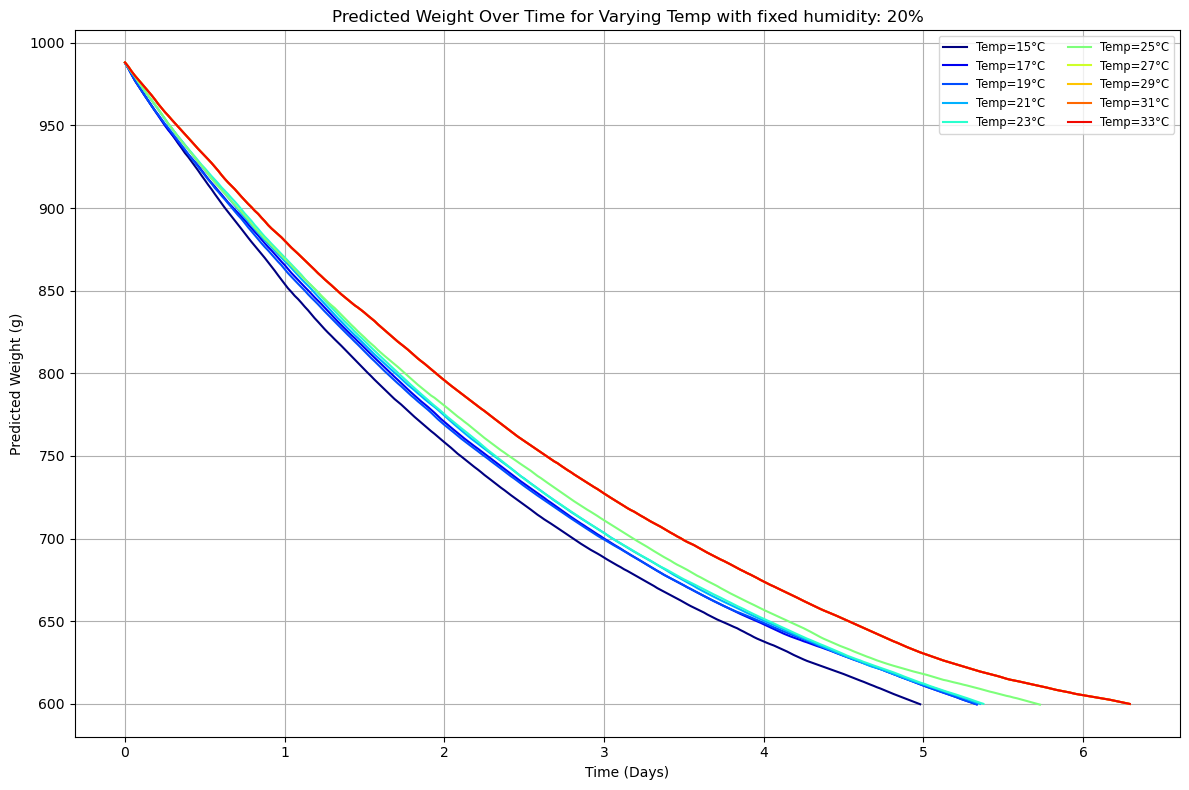

User suggested input values: temperature: 20C, lag_weights: ['0.992', '0.996', '1.000']


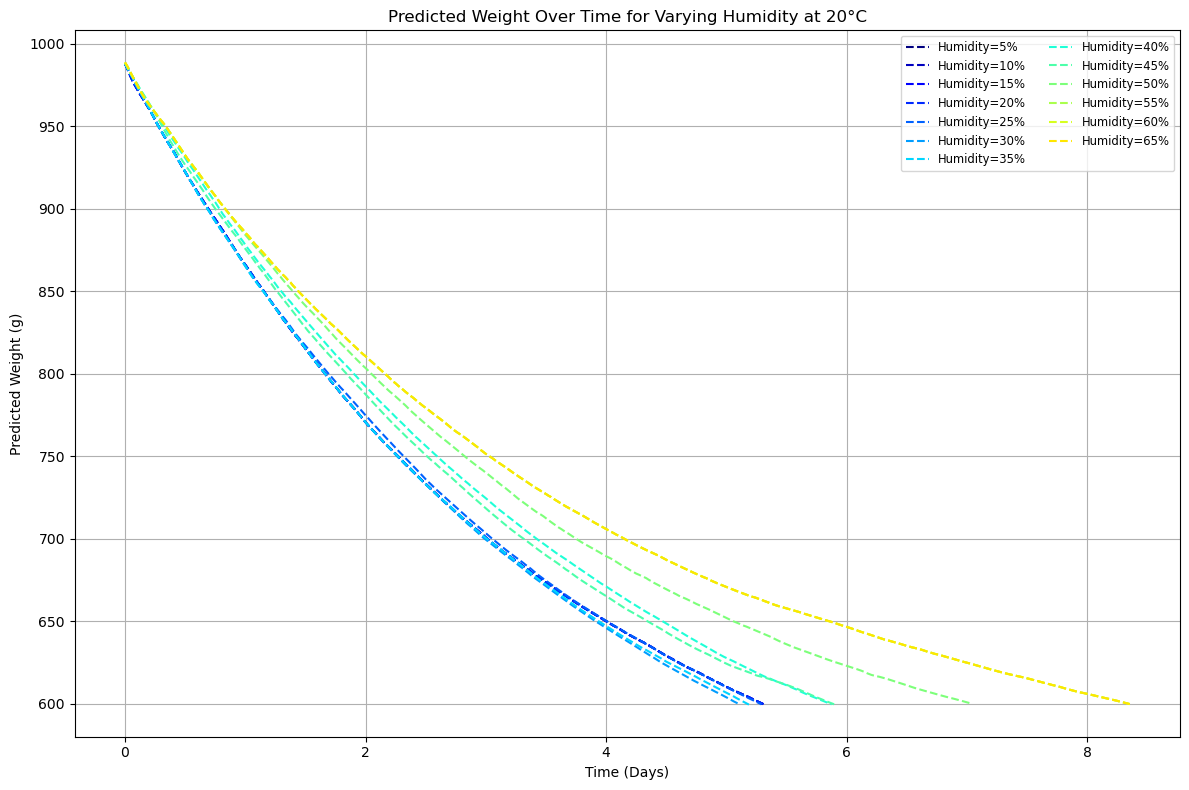

In [18]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# Set the temperature and humidity for the plots
humidity = 20
lag_weights = [previous_weight_3, previous_weight_2, previous_weight_1]
print(f"User suggested input values: Humidity: {humidity}%, lag_weights: {[f'{w:.3f}' for w in lag_weights]}")

# Create color maps
colors_temp = cm.jet(np.linspace(0, 1, 11))  # For temperatures 5–35
colors_hum = cm.jet(np.linspace(0, 1, 19))   # For humidity 5–60

# --- Varying Temperature Plot ---

START_TEMP = 15
END_TEMP = 35
STEP_TEMP = 2

plt.figure(figsize=(12, 8))

for i, prev_temp in enumerate(range(START_TEMP, END_TEMP, STEP_TEMP)):
    time_list = []
    weight_list = []
    lags = lag_weights.copy()

    for future_time in range(MAX_TIME):
        input_df = predict_future_weight(future_time, prev_temp, humidity, lags)
        predicted_weight = model.predict(input_df)[0]  # or however your model predicts

        # Update lag weights: shift and insert new weight
        lags = [predicted_weight] + lags[:-1]

        time_list.append(future_time)
        weight_list.append(predicted_weight)

        if predicted_weight < NORMARLIZED_CURE_WEIGHT:
            break

    plt.plot([t / 48 for t in time_list], [w * 1000 for w in weight_list],
             label=f'Temp={prev_temp}°C', color=colors_temp[i])

plt.xlabel('Time (Days)')
plt.ylabel('Predicted Weight (g)')
plt.title(f'Predicted Weight Over Time for Varying Temp with fixed humidity: {humidity}%')
plt.legend(ncol=2, fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Varying Humidity Plot ---

temperature = 20
print(f"User suggested input values: temperature: {temperature}C, lag_weights: {[f'{w:.3f}' for w in lag_weights]}")

plt.figure(figsize=(12, 8))

START_HUM = 5
END_HUM = 70
STEP_HUM = 5

for i, prev_humidity in enumerate(range(START_HUM, END_HUM, STEP_HUM)):
    time_list = []
    weight_list = []
    lags = lag_weights.copy()

    for future_time in range(MAX_TIME):
        input_df = predict_future_weight(future_time, temperature, prev_humidity, lags)
        predicted_weight = model.predict(input_df)[0]

        lags = [predicted_weight] + lags[:-1]

        time_list.append(future_time)
        weight_list.append(predicted_weight)

        if predicted_weight < NORMARLIZED_CURE_WEIGHT:
            break

    plt.plot([t / 48 for t in time_list], [w * 1000 for w in weight_list],
             label=f'Humidity={prev_humidity}%', color=colors_hum[i], linestyle='dashed')

plt.xlabel('Time (Days)')
plt.ylabel('Predicted Weight (g)')
plt.title(f'Predicted Weight Over Time for Varying Humidity at {temperature}°C')
plt.legend(ncol=2, fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()


### 3D Visualization of Temperature and Humidity Effects on Curing Time

This section uses a 3D surface plot to explore how both **temperature** and **humidity** simultaneously influence the curing time of biltong (jerky). The goal is to visualize the interaction between these two environmental variables and assess their combined impact on the drying process.

#### **Key Points**:
- The grid is generated by iterating over a range of temperatures (15–35 °C) and humidity levels (5–65%) in fixed steps.
- For each temperature-humidity pair, the model predicts the curing time based on sequential updates of lagged weight values.
- If the predicted weight drops below the curing threshold (`NORMARLIZED_CURE_WEIGHT`), the curing time is recorded; otherwise, the maximum allowed time is assigned.

#### **Observation**:
- The resulting surface illustrates how curing time changes across the temperature-humidity spectrum.
- However, **a clear distortion is visible in the region of high temperature (about 25C and above) and low humidity as well as low tempratures and high humidity**, due to the model’s lack of diverse training data in those conditions.
- This limitation causes the model to generalize poorly, predicting slower curing at high temperatures when paired with low humidity—an unrealistic outcome as well as low temperatures with high humidity.

The 3D plot provides an intuitive way to analyze and understand model behavior, but it also exposes data weaknesses that must be addressed for better real-world predictions.


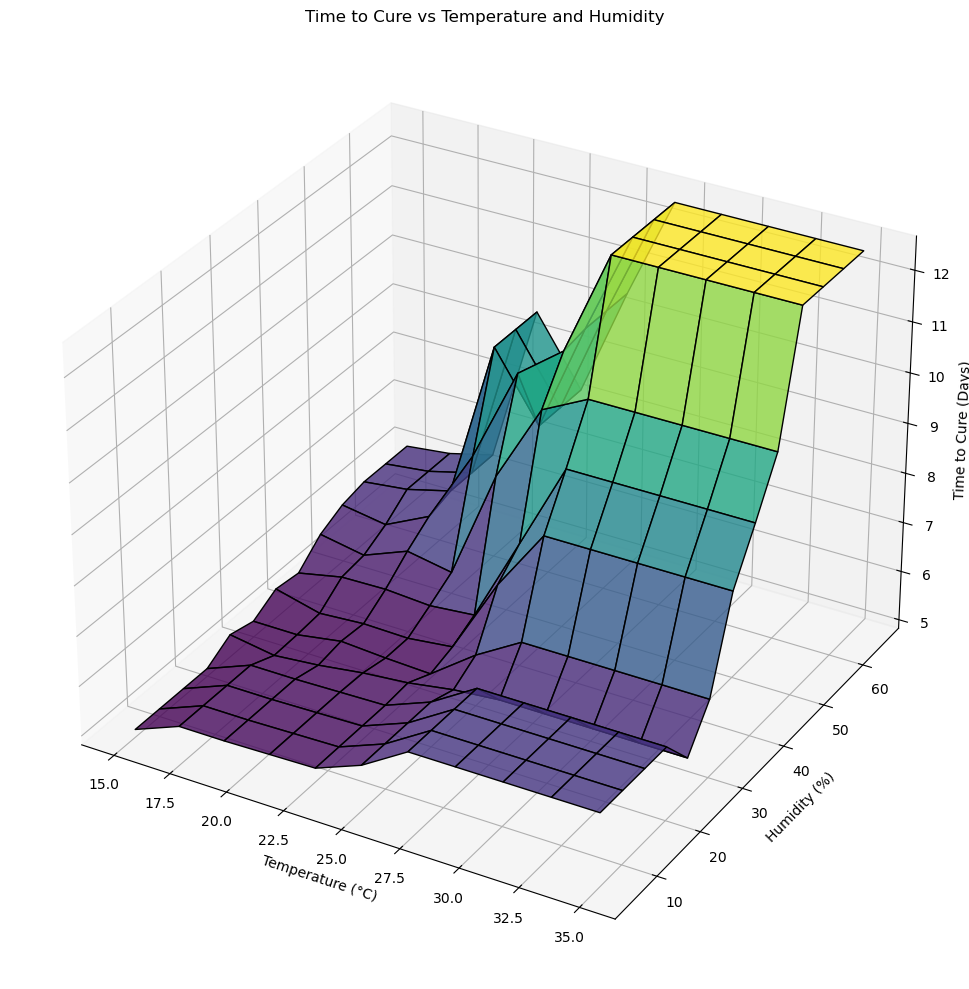

In [19]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Define parameters
temps = np.arange(15, 36, 2)
hums = np.arange(5, 70, 5)

# For 3D plotting
T, H = np.meshgrid(temps, hums)
CureTimes = np.zeros_like(T, dtype=float)

for i, temp in enumerate(temps):
    for j, hum in enumerate(hums):
        lags = lag_weights.copy()
        for future_time in range(MAX_TIME):
            input_df = predict_future_weight(future_time, temp, hum, lags)
            predicted_weight = model.predict(input_df)[0]
            lags = [predicted_weight] + lags[:-1]
            if predicted_weight < NORMARLIZED_CURE_WEIGHT:
                CureTimes[j, i] = future_time / 48  # Convert to days
                break
        else:
            CureTimes[j, i] = MAX_TIME / 48  # Didn't cure

# Plot
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(T, H, CureTimes, cmap='viridis', edgecolor='k', alpha=0.8)

ax.set_xlabel('Temperature (°C)')
ax.set_ylabel('Humidity (%)')
ax.set_zlabel('Time to Cure (Days)')
ax.set_title('Time to Cure vs Temperature and Humidity')

plt.tight_layout()
plt.show()
